## Домашнее задание к уроку "Урок 4. Алгоритм построения дерева решений"

**1\. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)**

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

from sklearn import model_selection
from math import log

In [2]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=175)

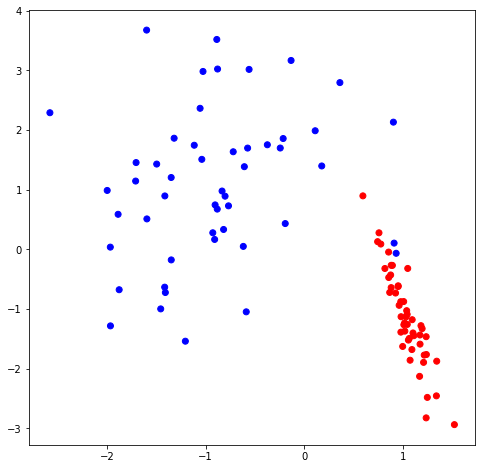

In [3]:
# визуализируем сгенерированные данные
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)
plt.show()

In [4]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# Реализуем класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [6]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1     # "impurity" - "нечистота", степень неопределенности
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [7]:
# Расчет качества
def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0]) # для правого (1-p)
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения с минимальным количеством элементов в листе
def find_best_split(data, labels, min_leaf = 0):

#     print(min_leaf)
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее заявленного числа элементов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
#                 print(len(true_data), len(false_data))
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции с максимальным количеством листов и минимальным количеством элементов в листе
def build_tree(data, labels, count_leaves = 0, max_count_leaves = 0, min_leaf = 0):

    # если есть ограничение по количеству листов
    if max_count_leaves != 0:
        if count_leaves < max_count_leaves:
            quality, t, index = find_best_split(data, labels, min_leaf)
            print("count_leaves", count_leaves)
            count_leaves += 1

            if quality == 0:
                return Leaf(data, labels)
        else:
            return Leaf(data, labels)
    else:
        quality, t, index = find_best_split(data, labels, min_leaf)
        print("count_leaves", count_leaves)
        count_leaves += 1
        if quality == 0:
            return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, count_leaves, max_count_leaves)
    false_branch = build_tree(false_data, false_labels, count_leaves, max_count_leaves)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
# Проход объекта по дереву для его классификации
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
# Предсказание деревом для всего датасета
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
# Функция подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [14]:
# Разобьем выборку на обучающую и тестовую
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [15]:
# Построим дерево по обучающей выборке с ограниченем минимального количества элементов в листе
my_tree = build_tree(train_data, train_labels, min_leaf = 15)

count_leaves 0
count_leaves 1
count_leaves 1
count_leaves 2
count_leaves 2
count_leaves 3
count_leaves 3


In [16]:
# Напечатаем ход нашего дерева с ограниченем минимального количества элементов в листе
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог 0.11317272734241479
--> True:
  Прогноз: 1
--> False:
  Индекс 1
  Порог -0.26692958777901943
  --> True:
    Прогноз: 0
  --> False:
    Индекс 0
    Порог 0.8582481994984963
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1


In [17]:
# Получим ответы для обучающей выборки с ограниченем минимального количества элементов в листе
train_answers = predict(train_data, my_tree)

In [18]:
# И получим ответы для тестовой выборки с ограниченем минимального количества элементов в листе
answers = predict(test_data, my_tree)

In [19]:
# Точность на обучающей выборке с ограниченем минимального количества элементов в листе
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

100.0

In [20]:
# Точность на тестовой выборке с ограниченем минимального количества элементов в листе
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

93.33333333333333

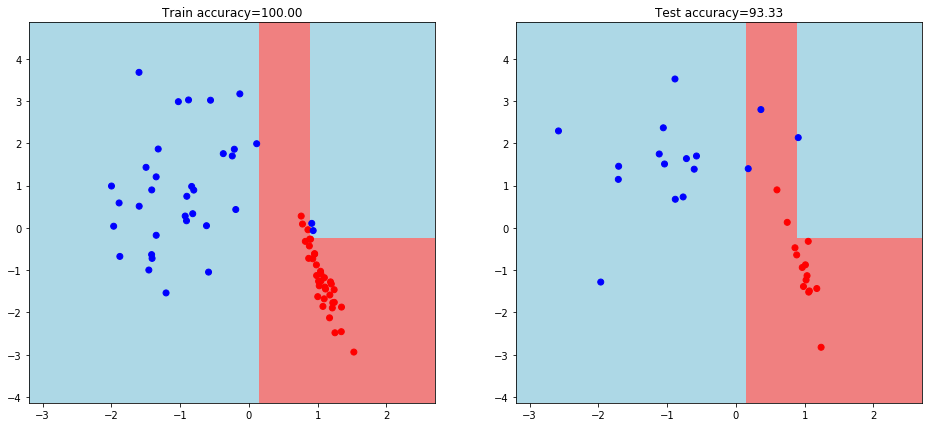

In [21]:
# Визуализируем дерево на графике с ограниченем минимального количества элементов в листе
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()

In [22]:
# Построим дерево по обучающей выборке с ограниченем максимального количества листов
my_tree = build_tree(train_data, train_labels, max_count_leaves=2)

count_leaves 0
count_leaves 1
count_leaves 1


In [23]:
# Напечатаем ход нашего дерева с ограниченем максимального количества листов
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог 0.11317272734241479
--> True:
  Прогноз: 1
--> False:
  Индекс 1
  Порог -0.26692958777901943
  --> True:
    Прогноз: 0
  --> False:
    Прогноз: 0


In [24]:
# Получим ответы для обучающей выборки с ограниченем максимального количества листов
train_answers = predict(train_data, my_tree)

In [25]:
# И получим ответы для тестовой выборки с ограниченем максимального количества листов
answers = predict(test_data, my_tree)

In [26]:
# Точность на обучающей выборке с ограниченем максимального количества листов
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

97.14285714285714

In [27]:
# Точность на тестовой выборке с ограниченем максимального количества листов
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

90.0

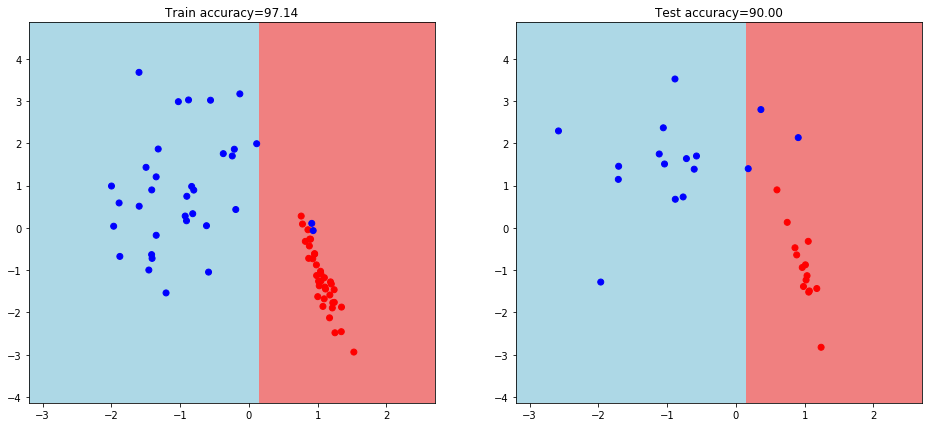

In [28]:
# Визуализируем дерево на графике с ограниченем максимального количества листов
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()

**2*\.  Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.
В материалах также есть пример скрипта для расчета дерева - Lesson_4_script, им можно воспользоваться аналогично тому, как это было на предыдущих уроках.**

In [29]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 5, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450, 800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]], dtype = np.float64)
y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype = np.float64)


In [30]:
x = X[2,:]
print(x)
print(y)
print(x >= 1000)
print(y[x >= 1000])
right_1 = (y[x >= 1000] == 0)
right_2 = (y[x >= 1000] == 1)
print('Нулей:', right_1.sum(), 'единиц:', right_2.sum())

[ 500.  700.  750.  600. 1450.  800. 1500. 2000.  450. 1000.]
[0. 0. 1. 0. 1. 0. 1. 0. 1. 1.]
[False False False False  True False  True  True False  True]
[1. 1. 0. 1.]
Нулей: 1 единиц: 3


In [31]:
def calc_inform(x, y, t):
    qty_all = len(y)
    y_left = y[x < t]
    y_right = y[x >= t]
    qty_left = len(y[x < t])
    qty_right = qty_all - qty_left

    # Критерий информативности не будет равен бесконечности в таком случае,
    # но и считать его особо смысла нет, т.к. получается только одна ветвь
    if len(y_left) == 0 or len(y_right) == 0:
        return np.inf
    
    mean_left = np.mean(y[x < t])
    mean_right = np.mean(y[x >= t])

    p_left = ((y_left - mean_left)**2).sum() / qty_left

    p_right = ((y_right - mean_right)**2).sum() / qty_right

    # Нормировочный коэффициент для левого листа
    left_coef = qty_left / qty_all

    
    # Энтропийный критерий Шеннона для левого листа
    h_left = - p_left * log(p_left, 2) if p_left != 0 else 0
    
    # Энтропийный критерий Шеннона для правого листа
    h_right = - p_right * log(p_right, 2) if p_right != 0 else 0

    res = left_coef * h_left + (1 - left_coef) * h_right
    return res

In [32]:
# Расчет критерия информативности
def inform(labels):
    
    # расчёт среднего
    labels_mean = np.mean(labels) if len(labels) != 0 else 0
    
    # расчёт дисперсии значений
    p = np.sum((labels - labels_mean)**2)/len(labels) if labels_mean != 0 else 0
    
    # расчет критерия
    impurity = - p * log(p, 2) if p != 0 else 0
    
    return impurity

In [33]:
print(y[x >= 1000])
i = inform(y[x >= 1000])
print(i)

print(y[x < 1000])
i = inform(y[x < 1000])
print(i)

[1. 1. 0. 1.]
0.45281953111478324
[0. 0. 1. 0. 0. 1.]
0.4822055558760694


In [34]:
# Расчет прироста качества (при разбиении вершины дерева)
def quality_0(left_labels, right_labels):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    inform_left = inform(left_labels)
    inform_right = inform(right_labels)
    
    return p * inform_left + (1 - p) * inform_right

In [35]:
for t in x:
    print('Порог: {}, informativity = {} ({})'.format(t, calc_inform(x, y, t), quality_0(y[x < t], y[x >= t])))

Порог: 500.0, informativity = 0.4484270906660583 (0.4484270906660583)
Порог: 700.0, informativity = 0.4926183542018011 (0.4926183542018011)
Порог: 750.0, informativity = 0.4704511459715549 (0.4704511459715549)
Порог: 600.0, informativity = 0.5 (0.5)
Порог: 1450.0, informativity = 0.4926183542018011 (0.4926183542018011)
Порог: 800.0, informativity = 0.4941344853728565 (0.4941344853728565)
Порог: 1500.0, informativity = 0.5 (0.5)
Порог: 2000.0, informativity = 0.4484270906660583 (0.4484270906660583)
Порог: 450.0, informativity = inf (0.5)
Порог: 1000.0, informativity = 0.4704511459715549 (0.4704511459715549)
